<a href="https://colab.research.google.com/github/leonardoLavagna/PyTorch-Notebooks/blob/main/Notebook_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch Notebook 7
## Recurrent Neural Networks and Name Classification

## Recurrent Neural Networks
Recurrent Neural Networks (RNNs) are a particular kind of Neural Network that allow previous outputs to be used as inputs while having hidden states/layers. See https://en.wikipedia.org/wiki/Recurrent_neural_network for more details. Another important resource is the following https://karpathy.github.io/2015/05/21/rnn-effectiveness. The key idea of RNNs is that we are allowed to work with *sequences* of tensors with different relationships. For example with the name classification we will develop in the next section we will use a many-to-one relationship.

In [1]:
# Standard imports
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 

We will now build an example of RNN that we will later use for name classification. The model architecture is as follows.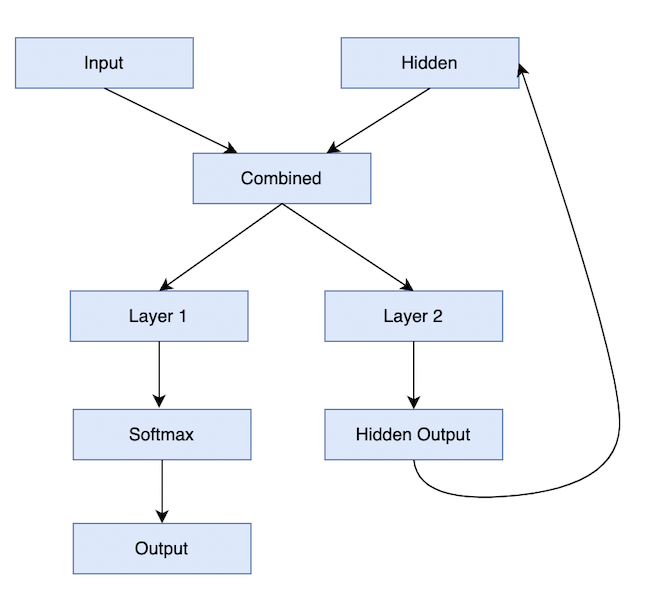

In [2]:
# Implement RNN from scratch rather than using nn.RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

## Name classification
We will use the previous RNN to carry out name (surname) classification: we will develop a model that predicts the country from an input surname.

In [3]:
# Import of self-defined helper functions
# Important: the python file utils.py needs uploaded when working with Google Colab
# or the file utiles.py should be in the same directory of this notebook when working locally
from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

In [4]:
# Important: to continue it is needed to import the folder called data. 
# To do so in Google Colab zip the folder, upload it, and unzip it with
# the command !unzip data.zip
category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_hidden = 128

In [5]:
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [6]:
# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

In [7]:
output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [8]:
# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

In [9]:
# Likelyhood of each category, so we want to return
# the index of the biggest value
output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [10]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

German


In [11]:
criterion = nn.NLLLoss()
# This parameter is of crucial importance
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [12]:
# Training
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [13]:
# Typical training loop
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

5000 5.0 2.3099 Gordov / Russian CORRECT
10000 10.0 1.4383 Bellincioni / Italian CORRECT
15000 15.0 0.1240 Vamvakidis / Greek CORRECT
20000 20.0 2.2819 Hodgson / Scottish WRONG (English)
25000 25.0 2.7261 Falconer / German WRONG (English)
30000 30.0 3.1357 AuYong / Japanese WRONG (Chinese)
35000 35.0 0.8946 an / Vietnamese CORRECT
40000 40.0 0.6264 Ferreira / Portuguese CORRECT
45000 45.0 0.7066 Gatti / Italian CORRECT
50000 50.0 0.1860 Kawate / Japanese CORRECT
55000 55.00000000000001 2.3427 Wiater / German WRONG (Polish)
60000 60.0 2.1900 Thomson / Russian WRONG (Scottish)
65000 65.0 0.9890 Salvage / French CORRECT
70000 70.0 0.6887 Seighin / Irish CORRECT
75000 75.0 0.9971 Tai / Vietnamese WRONG (Chinese)
80000 80.0 2.4371 Felix / French WRONG (Spanish)
85000 85.0 2.7675 Comtois / Greek WRONG (French)
90000 90.0 0.9741 Wright / Scottish CORRECT
95000 95.0 0.0611 Aizawa / Japanese CORRECT
100000 100.0 0.0154 Gulishambarov / Russian CORRECT


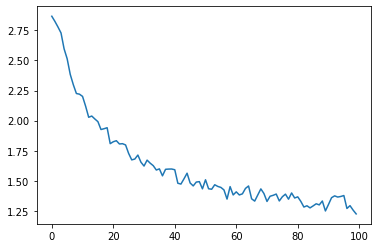

In [14]:
# Plot the losses   
plt.figure()
plt.plot(all_losses)
plt.show()

In [15]:
# Gets the raw input lines and make the predictions
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)

In [16]:
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    
    predict(sentence)

Input:Rossi

> Rossi
Italian
Input:Black

> Black
Scottish
Input:Bao

> Bao
Vietnamese
Input:Murakami

> Murakami
Japanese
Input:quit
